In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt


import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle


In [2]:
def mean_filter(data, number_of_points, step=1):
    mean_feature = []
    for i in range(0, number_of_points):
        mean_feature.append(np.mean(data[0: i+1]))
    if number_of_points > 1:
        for i in range(0, len(data) - number_of_points, step):
            mean_feature.append(
                np.mean(data[i: number_of_points + i]))
    else:
        return data
    return np.array(mean_feature)

In [3]:
def name_data(voluntary, key):
    
    data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

    if key == 'S1_Synched':
        name = 'S1'
        sincro = '_Synched'
    
    elif key == 'S2_Synched':
        name = 'S2'
        sincro = '_Synched'

    else:
        name = key
        sincro = ''

    arquivo = name + '_Subject_' + voluntary + sincro + '_Sit_and_Stand.csv'
    
    return arquivo, name, sincro

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [4]:
''' Alterar o número do voluntário e a chave da repetição'''

voluntary = 1
key = 'S1_Synched'

voluntary = str(voluntary)


In [5]:
''' Voluntário Referência'''

ref_voluntary = 1 
ref_key = 'S2_Synched'

ref_voluntary = str(ref_voluntary)

In [6]:
archive, name, sincro = name_data(voluntary, key)
ref_archive, ref_name, ref_sincro = name_data(ref_voluntary, ref_key)
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

In [7]:
data = pd.read_csv(data_path + archive, sep = ';')
ref_data = pd.read_csv(data_path + ref_archive, sep = ';')

### Separando os dados de aceleração para cada sensor

'Hip' 'RightUpLeg' 'LeftUpLeg' 'Head' 'Neck' 'Spine3' 'Spine2' 'Spine1' 'Spine'

In [8]:
Hip = data.iloc[:,0:3].values
RightUpLeg = data.iloc[:,3:6].values
LeftUpLeg = data.iloc[:,6:9].values
Head = data.iloc[:,9:12].values
Neck = data.iloc[:,12:15].values
Spine3 = data.iloc[:,15:18].values
Spine2 = data.iloc[:,18:21].values
Spine1 = data.iloc[:,21:24].values
Spine = data.iloc[:,24:27].values

In [9]:
angle_rad_hip, angle_hip = acc_to_angle(Hip)
angle_rad_right_up_leg, angle_right_up_leg = acc_to_angle(RightUpLeg)
angle_rad_left_up_leg, angle_left_up_leg = acc_to_angle(LeftUpLeg)
angle_rad_head, angle_head = acc_to_angle(Head)
angle_rad_neck, angle_neck = acc_to_angle(Neck)
angle_rad_spine3, angle_spine3 = acc_to_angle(Spine3)
angle_rad_spine2, angle_spine2 = acc_to_angle(Spine2)
angle_rad_spine1, angle_spine1 = acc_to_angle(Spine1)
angle_rad_spine, angle_spine = acc_to_angle(Spine)

In [10]:
# Definindo a frequência de amostragem
freq_amostragem = 120


''' Alterar janela do filtro '''
window_size_s = 0.1


# Definindo o número de amostras a serem filtrados
number_of_points = int(round(freq_amostragem * window_size_s))

# definindo o tempo em segundos das amostras
t_right_up_leg = np.linspace(0, len(angle_right_up_leg) / freq_amostragem, len(angle_right_up_leg))
t_left_up_leg = np.linspace(0, len(angle_left_up_leg) / freq_amostragem, len(angle_left_up_leg))
t_hip = np.linspace(0, len(angle_hip) / freq_amostragem, len(angle_hip))
t_head = np.linspace(0, len(angle_head) / freq_amostragem, len(angle_head))
t_neck = np.linspace(0, len(angle_neck) / freq_amostragem, len(angle_neck))
t_spine3 = np.linspace(0, len(angle_spine3) / freq_amostragem, len(angle_spine3))
t_spine2 = np.linspace(0, len(angle_spine2) / freq_amostragem, len(angle_spine2))
t_spine1 = np.linspace(0, len(angle_spine1) / freq_amostragem, len(angle_spine1))
t_spine = np.linspace(0, len(angle_spine) / freq_amostragem, len(angle_spine))

In [11]:
# Aplicar o filtro em cada um dos sensores
angle_right_up_leg_mean = mean_filter(angle_right_up_leg, number_of_points, step=1)
angle_left_up_leg_mean = mean_filter(angle_left_up_leg, number_of_points, step=1)
angle_hip_mean = mean_filter(angle_hip, number_of_points, step=1)
angle_head_mean = mean_filter(angle_head, number_of_points, step=1)
angle_neck_mean = mean_filter(angle_neck, number_of_points, step=1)
angle_spine3_mean = mean_filter(angle_spine3, number_of_points, step=1)
angle_spine2_mean = mean_filter(angle_spine2, number_of_points, step=1)
angle_spine1_mean = mean_filter(angle_spine1, number_of_points, step=1)
angle_spine_mean = mean_filter(angle_spine, number_of_points, step=1)

# Aplicando o DTW

In [12]:
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'

if key == 'S1_Synched' or key == 'S1':
    video_S = 'S1'
    
elif key == 'S2_Synched' or key == 'S2':
    video_S = 'S2'

else:
    print('Não possui vídeo correspondente a esses dados')

In [13]:
video_name = video_path + video_S + '_PG1_Subject_' + voluntary + '_L.avi'
ref_video_name = video_path + ref_name + '_PG1_Subject_' + ref_voluntary + '_L.avi'


# Frequencia dos dados

freq_IMU = 120

n_frames, fps = count_frames(video_name)

In [14]:
caminho = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'
arquivo = 'Start_End_Sit_and_Stand.csv'

start_end = pd.read_csv(caminho + arquivo, sep = ';')
start_end

,Description,S2_Subject_1_Synched,S1_Subject_1_Synched,S1_Subject_10_Synched,S2_Subject_10_Synched,S2_Subject_13_Synched,S1_Subject_13_Synched
0,IMU_start,524,13364,2100,9776,10268,11688
1,IMU_end,1316,14256,3392,11348,11684,12660
2,frame_start,131,3341,525,2444,2567,2922
3,frame_end,329,3564,848,2837,2921,3165


In [15]:
ref_start_frame = start_end.loc[2 ,ref_name + '_Subject_' + ref_voluntary + ref_sincro]
ref_start_frame

131

In [16]:
ref_LeftUpLeg = ref_data.iloc[:,6:9].values
ref_Spine1 = ref_data.iloc[:,21:24].values

ref_angle_rad_left_up_leg, ref_angle_left_up_leg = acc_to_angle(ref_LeftUpLeg)
ref_angle_rad_spine1, ref_angle_spine1 = acc_to_angle(ref_Spine1)

ref_angle_left_up_leg_mean = mean_filter(ref_angle_left_up_leg, number_of_points, step=1)
ref_angle_spine1_mean = mean_filter(ref_angle_spine1, number_of_points, step=1)

In [17]:
distance_left_up_leg, paths_left_up_leg = fastdtw(ref_angle_left_up_leg_mean, angle_left_up_leg_mean, dist=euclidean)
distance_spine1, paths_spine1 = fastdtw(ref_angle_spine1_mean, angle_spine1_mean, dist=euclidean)

In [18]:
paths_left_up_leg = np.array(paths_left_up_leg)
paths_spine1 = np.array(paths_spine1)

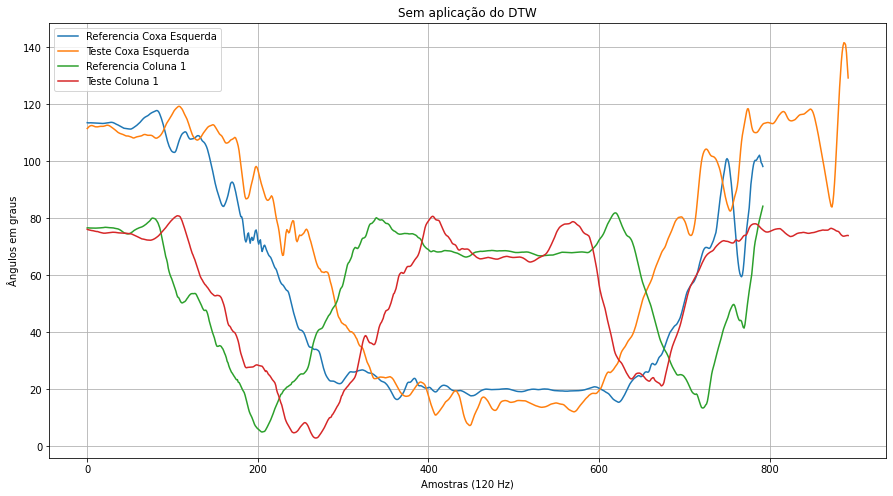

In [19]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_left_up_leg_mean, label = 'Referencia Coxa Esquerda')
plt.plot(angle_left_up_leg_mean, label = 'Teste Coxa Esquerda')
plt.plot(ref_angle_spine1_mean, label = 'Referencia Coluna 1')
plt.plot(angle_spine1_mean, label = 'Teste Coluna 1')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.title('Sem aplicação do DTW')
plt.grid()
plt.show()

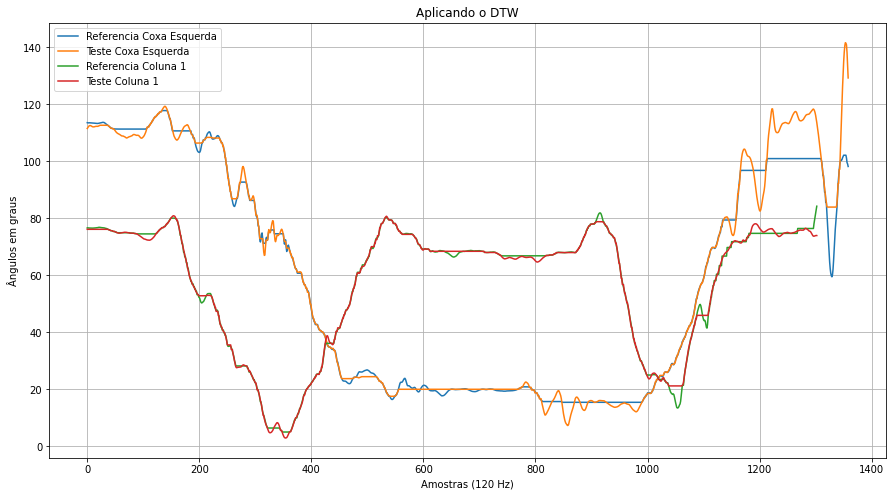

In [20]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_left_up_leg_mean[paths_left_up_leg[:,0]], label = 'Referencia Coxa Esquerda')
plt.plot(angle_left_up_leg_mean[paths_left_up_leg[:,1]], label = 'Teste Coxa Esquerda')
plt.plot(ref_angle_spine1_mean[paths_spine1[:,0]], label = 'Referencia Coluna 1')
plt.plot(angle_spine1_mean[paths_spine1[:,1]], label = 'Teste Coluna 1')
#plt.scatter(pose_IMU_ref,)
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.title('Aplicando o DTW')
plt.grid()
plt.show()

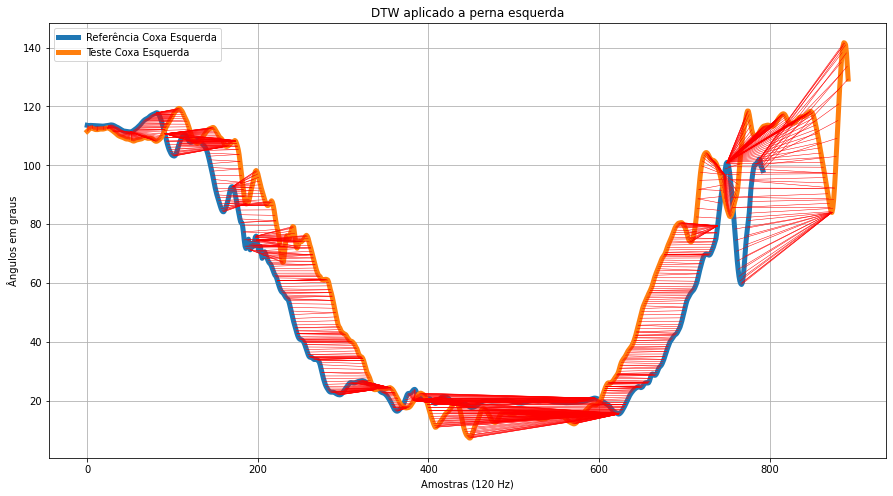

In [21]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(ref_angle_left_up_leg_mean, label = 'Referência Coxa Esquerda', linewidth=5)
plt.plot(angle_left_up_leg_mean, label = 'Teste Coxa Esquerda', linewidth=5)
for i in range(len(paths_left_up_leg[:, 0])):
    plt.plot([paths_left_up_leg[i, 0], paths_left_up_leg[i, 1]], [ref_angle_left_up_leg_mean[paths_left_up_leg[i,0]], 
             angle_left_up_leg_mean[paths_left_up_leg[i,1]]], 'r', linewidth=0.5)
plt.legend()
plt.title('DTW aplicado a perna esquerda')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
plt.savefig('DTW aplicado a perna esquerda.png')
plt.show()


In [ ]:
plt.figure(figsize=[15,8])
plt.plot(ref_angle_spine1_mean, label = 'Referência Coluna 1', linewidth=5)
plt.plot(angle_spine1_mean, label = 'Teste Coluna 1', linewidth=5)

for i in range(len(paths_spine1[:, 0])):
    plt.plot([paths_spine1[i, 0], paths_spine1[i, 1]], [ref_angle_spine1_mean[paths_spine1[i,0]], 
                                                        angle_spine1_mean[paths_spine1[i,1]]], 'r', linewidth=0.5)
plt.legend()
plt.title('DTW aplicado a Coluna')
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid()
plt.savefig('DTW aplicado a Coluna.png')
plt.show()


In [ ]:
estimated_targets_left_up_leg = [ 114, 297, 621, 750]
estimated_targets_spine1 = [ 79, 205, 338, 619, 722, 792]


markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_left_up_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_spine1 = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
#phases_colors = ['black', 'gray', 'red', 'purple', 'yellow', 'green',]


plt.figure(figsize=[15,8])
plt.plot(ref_angle_left_up_leg_mean, label='Perna')
plt.plot(ref_angle_spine1_mean, label='Tronco', linestyle='-.')

for i in range(len(estimated_targets_left_up_leg)):    
    plt.scatter(estimated_targets_left_up_leg[i], ref_angle_left_up_leg_mean[estimated_targets_left_up_leg[i]], 
            marker=markers[i], color='black', label=rowing_phases_left_up_leg[i])
    plt.scatter(estimated_targets_left_up_leg[i], ref_angle_spine1_mean[estimated_targets_left_up_leg[i]], 
            marker=markers[i], color='black')
    
for i in range(len(estimated_targets_spine1)):    
    plt.scatter(estimated_targets_spine1[i], ref_angle_left_up_leg_mean[estimated_targets_spine1[i]], 
            marker=markers[i+4], color='gray', label=rowing_phases_spine1[i])
    plt.scatter(estimated_targets_spine1[i], ref_angle_spine1_mean[estimated_targets_spine1[i]], 
            marker=markers[i+4], color='gray')

plt.title('Fases do DTW para sentar e levantar')
plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Amostras (120 Hz)')
plt.grid(False)
plt.axis(True)
plt.savefig('Fases do DTW para sentar e levantar.jpeg', format = 'jpeg')
plt.show()


In [ ]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_left_up_leg[:, 0])):
    if paths_left_up_leg[i, 0] == estimated_targets_left_up_leg[k]:
        plt.plot([paths_left_up_leg[i, 0], paths_left_up_leg[i, 1]], [ref_angle_left_up_leg_mean[paths_left_up_leg[i,0]], 
                 angle_left_up_leg_mean[paths_left_up_leg[i,1]]], 'r', linewidth=2)
        k = k + 1
        if k == 4:
            k = 0
plt.plot(angle_left_up_leg_mean, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_left_up_leg_mean, color = 'g',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()





In [ ]:
k = 0
plt.figure(figsize=[15,8])
for i in range(len(paths_spine1[:, 0])):
    if paths_spine1[i, 0] == estimated_targets_spine1[k]:
        plt.plot([paths_spine1[i, 0], paths_spine1[i, 1]], [ref_angle_spine1_mean[paths_spine1[i,0]], 
                 angle_spine1_mean[paths_spine1[i,1]]], 'r', linewidth=2)
        k = k + 1
        if k == 6:
            k = 0
plt.plot(angle_spine1_mean, color = 'b', label = 'Target', linewidth=5)
plt.plot(ref_angle_spine1_mean, color = 'g',  label = 'Reference', linewidth=5)
plt.legend()
plt.grid(True)
plt.axis(True)
plt.show()